In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from transformers import DeiTFeatureExtractor, DeiTModel
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

In [ ]:
# Data Loading
train_labels = pd.read_csv(r"C:\Users\risha\Downloads\Project Task 1 (1)\train_labels.txt", header=None).values.flatten()
val_labels = pd.read_csv(r"C:\Users\risha\Downloads\Project Task 1 (1)\val_labels.txt", header=None).values.flatten()

image_folder_train = r"C:\Users\risha\Downloads\Project Task 1 (1)\train_data"
image_folder_val = r"C:\Users\risha\Downloads\Project Task 1 (1)\val_data"
train_image_paths = [os.path.join(image_folder_train, img) for img in os.listdir(image_folder_train)]
val_image_paths = [os.path.join(image_folder_val, img) for img in os.listdir(image_folder_val)]




In [3]:

num_classes = len(np.unique(train_labels))

encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)

In [4]:
feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-base-distilled-patch16-224")
deit_model = DeiTModel.from_pretrained("facebook/deit-base-distilled-patch16-224")


c:\Users\risha\anaconda3\Lib\site-packages\transformers\models\deit\feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Image Preprocessing
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        inputs = feature_extractor(images=img, return_tensors="pt")
        with torch.no_grad():
            outputs = deit_model(**inputs)
            features = outputs.last_hidden_state[:, 0, :]
        images.append(features.squeeze(0).cpu().numpy())
    return np.array(images)

train_features = load_and_preprocess_images(train_image_paths)
val_features = load_and_preprocess_images(val_image_paths)

In [ ]:
# Dataset and Dataloader
class CustomTensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1: Train Acc=0.0243, Val Acc=0.1233
Epoch 2: Train Acc=0.0723, Val Acc=0.2317
Epoch 3: Train Acc=0.0990, Val Acc=0.3400
Epoch 4: Train Acc=0.1640, Val Acc=0.3900
Epoch 5: Train Acc=0.1987, Val Acc=0.4317
Epoch 6: Train Acc=0.2367, Val Acc=0.4817
Epoch 7: Train Acc=0.2723, Val Acc=0.5367
Epoch 8: Train Acc=0.3153, Val Acc=0.5683
Epoch 9: Train Acc=0.3383, Val Acc=0.6017
Epoch 10: Train Acc=0.3720, Val Acc=0.6333
Epoch 11: Train Acc=0.3987, Val Acc=0.6433
Epoch 12: Train Acc=0.4300, Val Acc=0.6633
Epoch 13: Train Acc=0.4527, Val Acc=0.6767
Epoch 14: Train Acc=0.4767, Val Acc=0.6950
Epoch 15: Train Acc=0.5070, Val Acc=0.7067
Epoch 16: Train Acc=0.5297, Val Acc=0.7167
Epoch 17: Train Acc=0.5443, Val Acc=0.7367
Epoch 18: Train Acc=0.5520, Val Acc=0.7483
Epoch 19: Train Acc=0.5733, Val Acc=0.7667
Epoch 20: Train Acc=0.5907, Val Acc=0.7800
Epoch 21: Train Acc=0.6013, Val Acc=0.7917
Epoch 22: Train Acc=0.6137, Val Acc=0.7867
Epoch 23: Train Acc=0.6340, Val Acc=0.8000
Epoch 24: Train Acc=

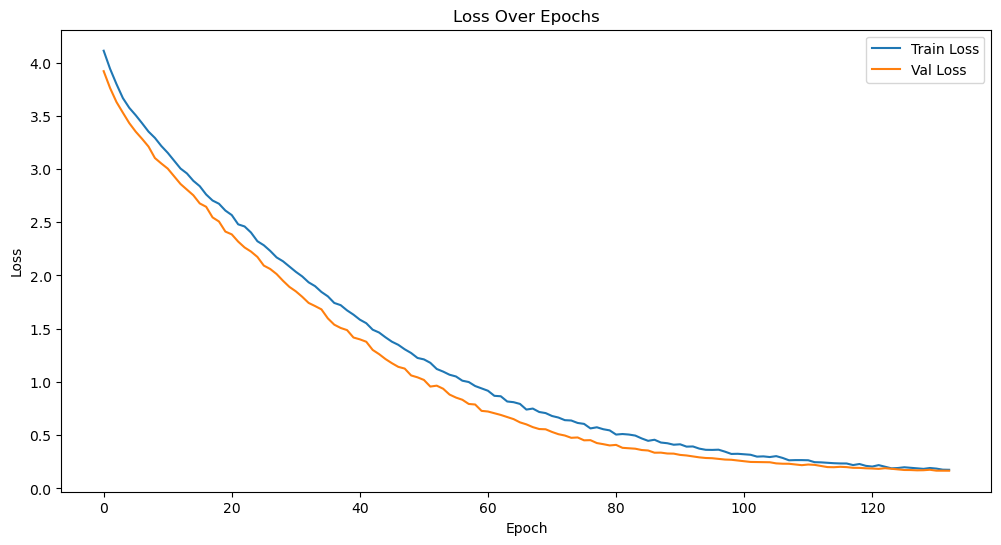

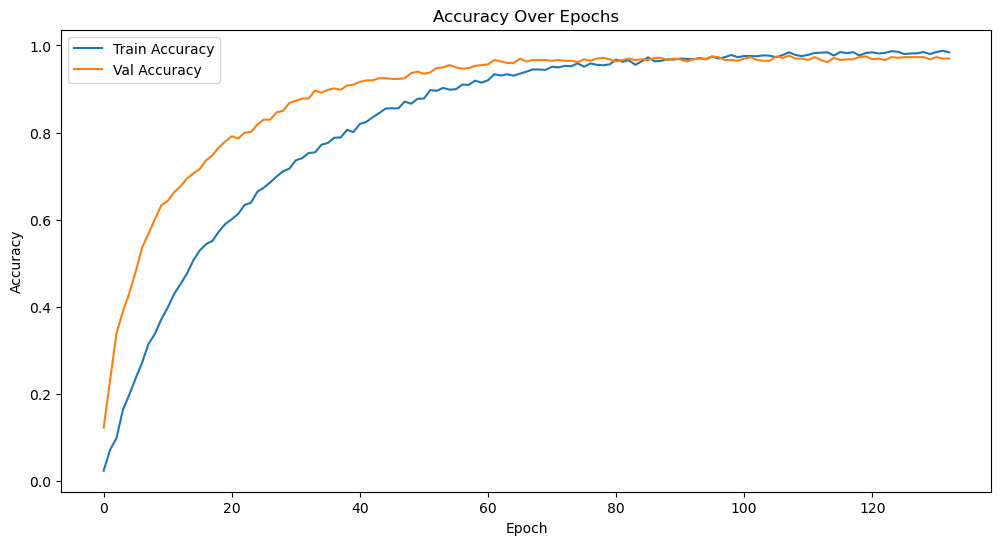

Best Validation Accuracy: 0.9766666666666667


In [ ]:
# Convert to tensors
X_train = torch.tensor(train_features, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_val = torch.tensor(val_features, dtype=torch.float32)
y_val = torch.tensor(val_labels, dtype=torch.long)

# DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Model Definition
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Hyperparameters
input_dim = train_features.shape[1]
dropout_rate = 0.3
learning_rate = 5e-5
patience = 25

# Initialize model, loss, optimizer
model = MLPClassifier(input_dim, num_classes, dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop with Early Stopping
best_val_acc = 0.0
epochs = 500
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_acc = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

print("Best Validation Accuracy:", best_val_acc)